In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [4]:
class FixedModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
        
    
    def create_fixed_model(self, h):
        #Creating AutoLSTM model and predicting with hyperparameter tuning by optuna backend. This is based upon the first training dataframe
        initial_dataset, *_ = TimeSeriesDataset.from_df(self.dfs[0])
        LSTMmodel = AutoLSTM(h = h, backend = "optuna")
        LSTMmodel.fit(dataset = initial_dataset)
        
        for i in range(len(self.dfs)):
            dataset, *_ = TimeSeriesDataset.from_df(self.dfs[i])
            y_hat = LSTMmodel.predict(dataset = dataset)
            start_date = datetime.strptime(self.dates[i], "%Y-%m-%d")
            horizon_dates = [start_date + timedelta(weeks=j) for j in range(h)]
        
            fc = pd.DataFrame(y_hat.ravel(), index = pd.to_datetime(horizon_dates))
            self.forecasts.append(fc)
    
    def create_graph(self):
        self.plotting_df.index = self.overall_df.index
        self.plotting_df["Real Data"] = self.overall_df[self.overall_df_value_col]
        
        for i in range(len(self.forecasts)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            
            self.plotting_df[f"{english_date} Model"] = self.forecasts[i][0]
        
        self.plotting_df.iplot(xTitle = "Date", yTitle = "Count", title = "Fixed Parameter LSTM Predictions")
    
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mape[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmse[i]}")

        

In [5]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [6]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [8]:
Processor = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [9]:
Processor.dates

['2024-10-05', '2024-10-19', '2024-11-02', '2024-11-16', '2024-12-07']

In [7]:
Processor.dfs

[]

In [10]:
Processor.create_training_dfs(value_col = "value")

In [12]:
Processor.dfs[0]

,y,ds,unique_id
date,,,
2022-02-05,1092.0,2022-02-05,series_1
2022-02-12,1164.0,2022-02-12,series_1
2022-02-19,1493.0,2022-02-19,series_1
2022-02-26,1603.0,2022-02-26,series_1
2022-03-05,1791.0,2022-03-05,series_1
...,...,...,...
2024-09-07,223.0,2024-09-07,series_1
2024-09-14,319.0,2024-09-14,series_1
2024-09-21,293.0,2024-09-21,series_1


In [13]:
Processor.create_fixed_model(4)

[I 2025-02-25 19:57:13,676] A new study created in memory with name: no-name-f43fa6e0-e9d6-4e7b-af10-95b178ae2186
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 8.0 K  | train
5 | mlp_decoder     | MLP    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:57:37,552] Trial 0 finished with value: 99.32469177246094 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 128, 'learning_rate': 0.010074738765384523, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 7, 'input_size': -4, 'inference_input_size': -4}. Best is trial 0 with value: 99.32469177246094.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:57:45,889] Trial 1 finished with value: 487.11859130859375 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.0016653562940362502, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 1, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 99.32469177246094.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 20
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-02-25 19:57:55,599] Trial 2 finished with value: 900.4074096679688 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.08754665557282833, 'max_steps': 500, 'batch_size': 32, 'random_seed': 20, 'input_size': 256, 'inference_input_size': -4}. Best is trial 0 with value: 99.32469177246094.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 14
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:58:03,422] Trial 3 finished with value: 400.709228515625 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0009280735462026618, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 14, 'input_size': 64, 'inference_input_size': -4}. Best is trial 0 with value: 99.32469177246094.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-02-25 19:58:07,476] Trial 4 finished with value: 85.53596496582031 and parameters: {'encoder_hidden_size': 50, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 128, 'learning_rate': 0.003928734415671347, 'max_steps': 500, 'batch_size': 32, 'random_seed': 8, 'input_size': 64, 'inference_input_size': -4}. Best is trial 4 with value: 85.53596496582031.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-02-25 19:58:12,031] Trial 5 finished with value: 121.8807144165039 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 50, 'decoder_hidden_size': 64, 'learning_rate': 0.007364257321093037, 'max_steps': 500, 'batch_size': 32, 'random_seed': 5, 'input_size': 16, 'inference_input_size': -4}. Best is trial 4 with value: 85.53596496582031.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:58:20,127] Trial 6 finished with value: 81.2992172241211 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 128, 'learning_rate': 0.008146096242860374, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 2, 'input_size': 16, 'inference_input_size': -4}. Best is trial 6 with value: 81.2992172241211.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
-----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:58:35,616] Trial 7 finished with value: 88.68843078613281 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 5, 'decoder_hidden_size': 64, 'learning_rate': 0.0001849411074628946, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 10, 'input_size': 256, 'inference_input_size': -4}. Best is trial 6 with value: 81.2992172241211.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-02-25 19:58:44,874] Trial 8 finished with value: 49.795753479003906 and parameters: {'encoder_hidden_size': 100, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 256, 'learning_rate': 0.000295977995009147, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 8, 'input_size': -4, 'inference_input_size': -4}. Best is trial 8 with value: 49.795753479003906.
/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_auto.py:291: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[rank: 0] Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
--------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-02-25 19:58:49,923] Trial 9 finished with value: 429.5313415527344 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 10, 'decoder_hidden_size': 256, 'learning_rate': 0.0016620667848505255, 'max_steps': 500, 'batch_size': 16, 'random_seed': 7, 'input_size': 16, 'inference_input_size': -4}. Best is trial 8 with value: 49.795753479003906.
[rank: 0] Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 202 K  | train
4 | context_adapter | Linear        | 2.0 K  | train
5 | mlp_deco

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
Processor.forecasts[1]

,0
2024-10-19,355.325317
2024-10-26,343.785461
2024-11-02,372.736938
2024-11-09,446.946411


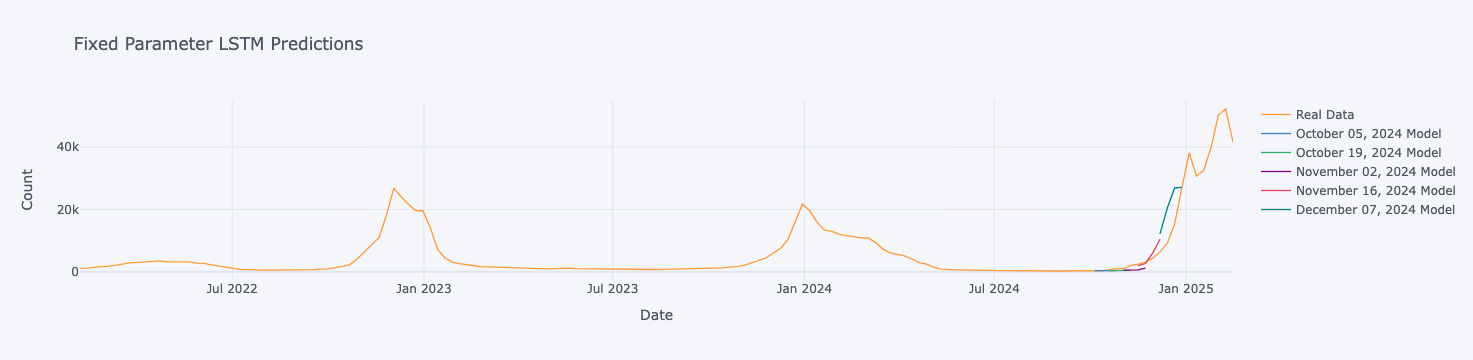

In [18]:
Processor.create_graph()

In [21]:
Processor.plotting_df.iloc[-16:]

,Real Data,"October 05, 2024 Model","October 19, 2024 Model","November 02, 2024 Model","November 16, 2024 Model","December 07, 2024 Model"
date,,,,,,
2024-11-02,976.0,NaN,372.736938,513.926453,NaN,NaN
2024-11-09,2032.0,NaN,446.946411,503.379211,NaN,NaN
2024-11-16,2439.0,NaN,NaN,606.986084,1918.572266,NaN
2024-11-23,3090.0,NaN,NaN,1139.595947,2630.948730,NaN
2024-11-30,4347.0,NaN,NaN,NaN,5945.317871,NaN
2024-12-07,6353.0,NaN,NaN,NaN,10413.576172,12142.966797
2024-12-14,9140.0,NaN,NaN,NaN,NaN,20418.509766
2024-12-21,15253.0,NaN,NaN,NaN,NaN,26864.626953
2024-12-28,26988.0,NaN,NaN,NaN,NaN,27087.871094


In [13]:
Processor.forecasts[1]

,0
2024-10-19,313.640442
2024-10-26,314.891418
2024-11-02,337.385864
2024-11-09,386.189758


In [14]:
Processor.overall_df

,value
date,
2022-02-05,1092.0
2022-02-12,1164.0
2022-02-19,1493.0
2022-02-26,1603.0
2022-03-05,1791.0
...,...
2025-01-18,32561.0
2025-01-25,39927.0
2025-02-01,50272.0


In [15]:
Processor.overall_df["value"].loc[Processor.forecasts[1].index]

2024-10-19     553.0
2024-10-26    1082.0
2024-11-02     976.0
2024-11-09    2032.0
Name: value, dtype: float64

In [16]:
Processor.calculate_metrics()

In [17]:
Processor.maes

[310.62237548828125,
 822.7231292724609,
 579.6495513916016,
 3583.8917846679688,
 4158.97509765625]

In [18]:
Processor.mses

[197492.42251734436,
 940566.9849962732,
 422049.5558118755,
 15314768.177381173,
 19204347.763413906]

In [19]:
Processor.mapes

[0.419445588320959,
 0.6515187046863857,
 0.2791815771823297,
 0.8549973928745299,
 0.3773134659164475]